## 1. Imports
---
<p>
Numpy: Math related stuff but mainly for linear algebra.
</p>
<p>
Pandas: Importing and processing data.
</p>
<p>
Random: Helps us randomize an array of items into a normal distrition.
</p>
<p>
Matplotlib: Plots the images and displays it nicely.
</p>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from PIL import Image

import pathlib
import imageio
import PIL
import h5py
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from keras.models import model_from_json
from keras import regularizers

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(69)

Using TensorFlow backend.


## 2. Data Organization
---
Now that we have defined our imports, lets go ahead and get our data imported and organized.

In [2]:
# Hyperparameters
standard_width = 150
standard_height = 150
image_channels = 3

training_data = []
prediction_data = []

# Get raw images from the Makeup collection and sort them checking they are unique.
raw_images = pathlib.Path('./kaggle/input/make-up-vs-no-make-up/data/makeup').glob('*.jpeg')
sorted_images_makeup = sorted([ image for image in raw_images])

# Get raw images from the No Makeup collection and sort them checking they are unique.
raw_images = pathlib.Path('./kaggle/input/make-up-vs-no-make-up/data/no_makeup').glob('*.jpeg')
sorted_images_noMakeup = sorted([ image for image in raw_images])

number_of_samples = len(sorted_images_noMakeup) + len(sorted_images_makeup)

print(len(sorted_images_makeup))
print(len(sorted_images_noMakeup))
print(number_of_samples)

# We need to build a 4D tensor that looks something like this
# [number_of_samples,standard_width,standard_height,image_channels]

# Path stores the relative path to the image while the makeup stores a boolean.
# Think about it as the input and the output of the CNN.
for path in sorted_images_makeup:
    im = Image.open(path) # Read Image
    im = im.resize((standard_width,standard_height)) # Reshape it to a standard size (w,h,3)
    image = np.array(im) # Convert into numpy array.
    training_data.append(image) # Push it into the training data.
    prediction_data.append(True)

# Path stores the relative path to the image while the makeup stores a boolean.
# Think about it as the input and the output of the CNN.
for path in sorted_images_noMakeup:
    im = Image.open(path) # Read Image
    im = im.resize((standard_width,standard_height)) # Reshape it to a standard size (w,h,3)
    image = np.array(im) # Convert into numpy array.
    training_data.append(image) # Push it into the training data.
    prediction_data.append(False)
    
training_data = np.asarray(training_data)

rng_state = np.random.get_state()
np.random.shuffle(training_data)
np.random.set_state(rng_state)
np.random.shuffle(prediction_data)
random.shuffle(training_data)

print('We have', len(training_data), 'training samples')
print(training_data)
print(training_data.shape)
#print('We are going to analyse',len(sorted_images),"images")

1062
444
1506
We have 1506 training samples
[[[[240 241 246]
   [239 240 245]
   [238 239 244]
   ...
   [243 244 249]
   [243 244 249]
   [242 243 248]]

  [[239 240 245]
   [239 240 245]
   [238 239 244]
   ...
   [243 244 249]
   [243 244 249]
   [242 243 248]]

  [[239 240 245]
   [238 239 244]
   [237 238 243]
   ...
   [243 244 249]
   [243 244 249]
   [242 243 248]]

  ...

  [[179 176 171]
   [182 175 167]
   [183 173 164]
   ...
   [249 229 220]
   [246 233 225]
   [241 236 230]]

  [[179 176 171]
   [182 175 167]
   [183 173 163]
   ...
   [249 229 218]
   [247 233 224]
   [243 236 228]]

  [[179 176 169]
   [182 175 165]
   [182 174 163]
   ...
   [252 228 218]
   [252 233 226]
   [244 233 227]]]


 [[[240 241 246]
   [239 240 245]
   [238 239 244]
   ...
   [243 244 249]
   [243 244 249]
   [242 243 248]]

  [[239 240 245]
   [239 240 245]
   [238 239 244]
   ...
   [243 244 249]
   [243 244 249]
   [242 243 248]]

  [[239 240 245]
   [238 239 244]
   [237 238 243]
   ...
 

## 3. Early Image Visualization
---
Now that we have all the paths for our images and lables for each one of them, we can check using matplotlib by ploting the images in real-time. Lets check #69 because why not.

(-0.5, 149.5, 149.5, -0.5)

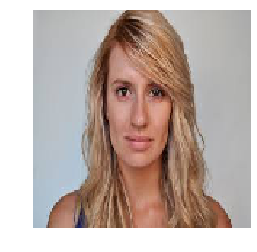

In [3]:
image = training_data[69]
plt.imshow(image)
plt.axis('off')

## 4. ConvNet
---
The Convolutional Neural Network will take an image as an input and return us if it has make-up or not. We have data in this moment made out of images and lables, so the input and the output of the network. We now need trainging and test data out of this data. For this, we need to randomly select makeup and no-makeup images for both collections. Also, normalization in this case is not absolutly needed, but we will apply it anyways just to make sure we don't have exploding gradients later.

Our architecture will consist of a Conv (2x2) + ReLu, then a Conv (4x4) + ReLu and finally a max pooling layer. We will repeat that 5 times, then we will flatten the result and feed it into 5 fully connected layers, ending on a Softmax. This means 7 Artificial Layers including the result layer. 

We have a total of 1506 images, we are going to use 500 for testing and 1006 for training. Lets start by getting that organized.

In [4]:
test_size = 500
training_images = training_data[:- test_size,:,:,:]
training_labels = prediction_data[:- test_size]
test_images = training_data[- test_size:,:,:,:]
test_labels = prediction_data[- test_size:]

print('Data size',len(training_data))
print('Training images',len(training_images))
print('Training labels', len(training_labels))
print('Test images',len(test_images))
print('Test labels',len(test_labels))

Data size 1506
Training images 1006
Training labels 1006
Test images 500
Test labels 500


In [5]:
image_width = 150
image_height = 150
image_channels = 3

#1 conv
model = models.Sequential()
model.add(layers.Conv2D(16, (2,2), padding="same", activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01),
                        activity_regularizer=regularizers.l2(0.01),
                        input_shape=(image_width,image_height,image_channels)))
model.add(layers.Conv2D(32, (4,4), padding="same", activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

#2 conv
model.add(layers.Conv2D(32, (2,2), padding="same", activation='relu'))
model.add(layers.Conv2D(64, (4,4), padding="same", activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

#3 conv
model.add(layers.Conv2D(64, (2,2), padding="same", activation='relu'))
model.add(layers.Conv2D(128, (4,4), padding="same", activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

#4 conv
model.add(layers.Conv2D(128, (2,2), padding="same", activation='relu'))
model.add(layers.Conv2D(256, (4,4), padding="same", activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

#5 conv
model.add(layers.Conv2D(256, (2,2), padding="same", activation='relu'))
model.add(layers.Conv2D(512, (4,4), padding="same", activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

# Flatten
model.add(layers.Flatten())

#1 dense
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.05))

#2 dense
model.add(layers.Dense(64, activation='relu'))

#3 dense
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.05))

#4 dense
model.add(layers.Dense(64, activation='relu'))

#5 dense
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.05))

# Softmax
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      208       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      8224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        4128      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
____

## 5. Training
Now that we have build a model and organized the data into a nice randomized batched, lets get started with training the beast! We need to define a few things first, like what type of optimizer we are going to use and the loss function. We are going to use Adam optimization and crossvalidation in this case.

In [ ]:
train_model = True

if train_model:
    model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

    print('There should be', len(training_images), '=', len(training_labels))
    print('There should be', len(test_images), '=', len(test_labels))
    print('training_images',len(training_images))
    print('training_lables',len(training_labels))

    history = model.fit(training_images, training_labels, batch_size=64, epochs=10)

    print(print('\nhistory dict:', history.history))

    test_results = model.evaluate(test_images, test_labels, batch_size=128)

    print('test loss, test acc:', test_results)

    print('\n# Generate predictions for 3 samples')
    predictions = model.predict(test_images[:3])
    print('predictions shape:', predictions.shape)
else:
    # load json and create model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("model.h5")
    print("Loaded model from disk")

There should be 1006 = 1006
There should be 500 = 500
training_images 1006
training_lables 1006
Epoch 1/10
1006/1006 [==============================] - 357s 354ms/sample - loss: 6285535.6496 - acc: 0.6491
Epoch 2/10
1006/1006 [==============================] - 379s 377ms/sample - loss: 2858293.4756 - acc: 0.6918
Epoch 3/10
1006/1006 [==============================] - 354s 352ms/sample - loss: 1131467.7058 - acc: 0.6918
Epoch 4/10
1006/1006 [==============================] - 447s 444ms/sample - loss: 404628.6478 - acc: 0.6918
Epoch 5/10
1006/1006 [==============================] - 325s 323ms/sample - loss: 165009.5359 - acc: 0.6918
Epoch 6/10
1006/1006 [==============================] - 313s 311ms/sample - loss: 98488.3036 - acc: 0.6918
Epoch 7/10
1006/1006 [==============================] - 313s 311ms/sample - loss: 79393.1949 - acc: 0.6918
Epoch 8/10
1006/1006 [==============================] - 321s 319ms/sample - loss: 70423.6946 - acc: 0.6918
Epoch 9/10
 512/1006 [==============>...

Now that we have trained our model, time for us to save it to disk, as we might want to use it later without having to train in all over again. For that we are going to use Keras and h5py in order to make a JSON representation of our model and store it in disk.

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Now, lets try to predict some cases. In this case, you will need to do some manual uploading of cases and run them yourself.

In [ ]:
path = "/kaggle/input/make-up-vs-no-make-up/data/data/makeup/makeup1036.jpeg"
# Get raw images from the Makeup collection and sort them checking they are unique.
im = Image.open(path) # Read Image
im = im.resize((standard_width,standard_height)) # Reshape it to a standard size (w,h,3)
image = np.array(im) # Convert into numpy array.
input_state = []
input_state.append(image)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(image_state)
print('predictions shape:', predictions.shape)